### Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.io import gbq
from math import e

pd.options.mode.chained_assignment = None  # default='warn'

### Functions

In [3]:
# Input: Data, Time-Array, Output: Heparin Rate at Input Timestamps
def f_rate(data, t):
    
    start = data['rel_starttime']/60 # Convert to hours
    end = data['rel_endtime']/60
    r = data['rate_by_weight']
    
    rate = np.empty(len(t))
    
    for i in range(len(t)):
        for j in range(len(data)):
            
            if t[i] >= start[j] and t[i] < end[j]:
                rate[i] = r[j]

    return rate

def f_kum(rate, t):
    
    kum = np.empty(len(t))
    
    for i in range(len(t)):
        
        if i == 0:
            kum[i] = 0
        else:
            kum[i] = (kum[i-1] + rate[i])
            
    kum = kum/t
    kum[0] = 0
    
    return np.around(kum, decimals=2)

# Input: Data, Time-Array, Hep_Rate-Array, Output: Amount of Heparin in Blood (Half-Life Time included)
def f(data, rate, t):
    
    start = data['rel_starttime']/60 # Convert to hours
    end = data['rel_endtime']/60
    
    hep_amount = np.empty(len(t))
    
    # Create temporary arrays
    temp_hep = np.empty(len(data))
    temp_t = np.empty(len(data))
    temp_r = np.empty(len(data))
    
    for i in range(len(t)):
        for j in range(len(data)):
            
            if (j == 0) and (t[i] >= start[j] and t[i] < end[j]):
                hep_amount[i] = rate[i]*(1-e**(-1*t[i]))
                temp_hep[j] = hep_amount[i]
                temp_t[j] = t[i]
                temp_r[j] = rate[i]
                
            elif t[i] >= start[j] and t[i] < end[j]:
                hep_amount[i] = temp_hep[j-1] + (rate[i]-temp_hep[j-1])*(1-e**((-1*(t[i]-temp_t[j-1]))))
                temp_hep[j] = hep_amount[i]
                temp_t[j] = t[i]
                temp_r[j] = rate[i]
    
    return np.around(hep_amount, decimals=2)

### Define Queries and Load Data from GBQ into Dataframes

In [4]:
query_hep = """
        SELECT *
        FROM `bachelorarbeit-heparin.mimic_data.cohort1_hep_data`
        """

query_ptt = """
        SELECT *
        FROM `bachelorarbeit-heparin.mimic_data.cohort1_ptt_data`
        WHERE rel_charttime >= 0
        AND rel_charttime < 1440
        """

df_hep = gbq.read_gbq(query_hep, project_id = "bachelorarbeit-heparin")

df_ptt = gbq.read_gbq(query_ptt, project_id = "bachelorarbeit-heparin")

hep_data = df_hep[['stay_id','rel_starttime','rel_endtime','rate_by_weight']]
ptt_data = df_ptt[['stay_id','rel_charttime','PTT']]
ptt_data['rel_charttime'] = np.floor(ptt_data['rel_charttime']/60).astype(int) # TO-DO (Floor'ing' increases inaccuracies)

Downloading: 100%|███████████████████████████████████████████████████████████| 15327/15327 [00:04<00:00, 3775.95rows/s]


### 1st Pharmacokinetic Model - Benchmark

In [5]:
t = np.arange(0.0, 24.0, 1)

case1_hep = pd.DataFrame(columns=['stay_id','rel_time','rate'])
fin1_df = pd.DataFrame(columns=['stay_id','rel_time','rate','pTT'])

case1_hep = case1_hep[0:0] # makes sure, that dataframe is empty, before for-loop starts

for key, item in hep_data.groupby(["stay_id"]):
    item.reset_index(inplace=True, drop=True)
    
    # Data Imputation:
    # 1. for-loop: if there are missing hep_intervals, insert the missing interval with rate=0
    # 2. if-condition: if hep_treatment ends before t=24, insert a row with rate=0 for the time between the end
    #                  of treatment and t=24
    
    for i in range(len(item)):
        
        if (item.iloc[i,1] != 0) and (item.iloc[i,1] != item.iloc[i-1,2]):
            item.loc[i-0.5] = item.iloc[i,0], item.iloc[i-1,2], item.iloc[i, 1], 0
            
    item.sort_index(inplace=True)
    item.reset_index(inplace=True, drop=True)
    
    if item.iloc[len(item)-1,2] < 1440:
        item.loc[len(item)] = item.iloc[len(item)-1,0], item.iloc[len(item)-1,2], 1440, 0
        
    # 1. Create an array, that contains the respective hep_rate for timestamps 0,1,2,...,23,24
    rate = f_rate(item, t)
    
    # Save time_array, amount_hep_array for each stay_id in case3_hep
    case1_hep = case1_hep.append({
        'stay_id': key,
        'rel_time': t,
        'rate': rate
    }, ignore_index=True)  
    
case1_hep.set_index('stay_id', inplace=True)

fin1_df = fin1_df[0:0] # makes sure, that dataframe is empty, before for-loop starts

# Save rate at given pTT-Measurement in fin1_df
for i in range(len(ptt_data)):
    
       fin1_df = fin1_df.append({
        'stay_id': ptt_data.iloc[i,0],
        'rel_time': ptt_data.iloc[i,1],
        'rate': case1_hep.loc[ptt_data.iloc[i,0]][1][ptt_data.iloc[i,1]],
        'pTT': ptt_data.iloc[i,2]
        },ignore_index=True)

### 2nd Pharmacokinetic Model

In [6]:
t = np.arange(0.0, 24.0, 1)

case2_hep = pd.DataFrame(columns=['stay_id','rel_time','kum_amount_hep/time'])
fin2_df = pd.DataFrame(columns=['stay_id','rel_time','kum_amount_hep/time','pTT'])

case2_hep = case2_hep[0:0] # makes sure, that dataframe is empty, before for-loop starts

for key, item in hep_data.groupby(["stay_id"]):
    item.reset_index(inplace=True, drop=True)
    
    # Data Imputation:
    # 1. for-loop: if there are missing hep_intervals, insert the missing interval with rate=0
    # 2. if-condition: if hep_treatment ends before t=24, insert a row with rate=0 for the time between the end
    #                  of treatment and t=24
    
    for i in range(len(item)):
        
        if (item.iloc[i,1] != 0) and (item.iloc[i,1] != item.iloc[i-1,2]):
            item.loc[i-0.5] = item.iloc[i,0], item.iloc[i-1,2], item.iloc[i, 1], 0
            
    item.sort_index(inplace=True)
    item.reset_index(inplace=True, drop=True)
    
    if item.iloc[len(item)-1,2] < 1440:
        item.loc[len(item)] = item.iloc[len(item)-1,0], item.iloc[len(item)-1,2], 1440, 0
        
    # Create an array, that contains the respective hep_rate for timestamps 0,1,2,...,23,24
    rate = f_rate(item, t)
    kum_by_time = f_kum(rate, t)
    
    # Save time_array, kum_amount_hep/time for each stay_id in case2_hep
    case2_hep = case2_hep.append({
        'stay_id': key,
        'rel_time': t,
        'kum_amount_hep/time': kum_by_time
    }, ignore_index=True)
    
case2_hep.set_index('stay_id', inplace=True)

fin2_df = fin2_df[0:0] # makes sure, that dataframe is empty, before for-loop starts

# Save amount_hep at given pTT-Measurement in fin2_df
for i in range(len(ptt_data)):
    
       fin2_df = fin2_df.append({
        'stay_id': ptt_data.iloc[i,0],
        'rel_time': ptt_data.iloc[i,1],
        'kum_amount_hep/time': case2_hep.loc[ptt_data.iloc[i,0]][1][ptt_data.iloc[i,1]],
        'pTT': ptt_data.iloc[i,2]
        },ignore_index=True)

C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


### 3rd Pharmacokinetic Model

In [7]:
t = np.arange(0.0, 24.0, 1)

case3_hep = pd.DataFrame(columns=['stay_id','rel_time','amount_hep'])
fin3_df = pd.DataFrame(columns=['stay_id','rel_time','amount_hep','pTT']) 

case3_hep = case3_hep[0:0] # makes sure, that dataframe is empty, before for-loop starts

for key, item in hep_data.groupby(["stay_id"]):
    item.reset_index(inplace=True, drop=True)
    
    # Data Imputation:
    # 1. for-loop: if there are missing hep_intervals, insert the missing interval with rate=0
    # 2. if-condition: if hep_treatment ends before t=24, insert a row with rate=0 for the time between the end
    #                  of treatment and t=24
    for i in range(len(item)):
        
        if (item.iloc[i,1] != 0) and (item.iloc[i,1] != item.iloc[i-1,2]):
            item.loc[i-0.5] = item.iloc[i,0], item.iloc[i-1,2], item.iloc[i, 1], 0
            
    item.sort_index(inplace=True)
    item.reset_index(inplace=True, drop=True)
    
    if item.iloc[len(item)-1,2] < 1440:
        item.loc[len(item)] = item.iloc[len(item)-1,0], item.iloc[len(item)-1,2], 1440, 0
    
    # 1. Create an array, that contains the respective hep_rate for timestamps 0,1,2,...,23,24
    # 2. Create an array, that contains the current amount_hep for timestamps 0,1,2,...,23,24
    rate = f_rate(item, t)
    amount_hep = f(item, rate, t)
    
    # Save time_array, amount_hep_array for each stay_id in case3_hep
    case3_hep = case3_hep.append({
        'stay_id': key,
        'rel_time': t,
        'amount_hep': amount_hep
    }, ignore_index=True)  
    
case3_hep.set_index('stay_id', inplace=True)

fin3_df = fin3_df[0:0] # makes sure, that dataframe is empty, before for-loop starts

# Save amount_hep at given pTT-Measurement in fin3_df
for i in range(len(ptt_data)):
    
       fin3_df = fin3_df.append({
        'stay_id': ptt_data.iloc[i,0],
        'rel_time': ptt_data.iloc[i,1],
        'amount_hep': case3_hep.loc[ptt_data.iloc[i,0]][1][ptt_data.iloc[i,1]],
        'pTT': ptt_data.iloc[i,2]
        },ignore_index=True)

C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in double_scalars
C:\Users\mikad\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


### Visual Comparison of Pharmacokinetic Models

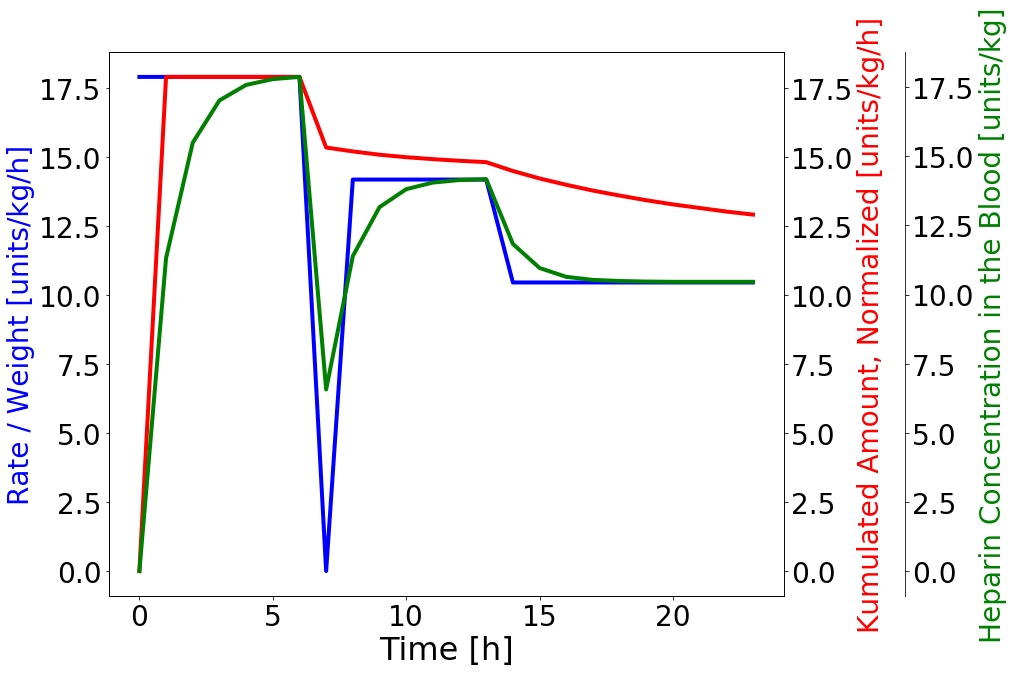

In [8]:
fig, ax = plt.subplots(figsize=(15,10))

axes = [ax, ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.18))

stay_id = 30006731

axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

axes[0].plot(t,case1_hep.loc[stay_id][1], color='b', linewidth=4)
axes[0].set_xlabel('Time [h]', fontsize=32)
axes[0].set_ylabel('Rate / Weight [units/kg/h]', color='b', fontsize=28)
axes[1].plot(t,case2_hep.loc[stay_id][1], color='r', linewidth=4)
axes[1].set_ylabel('Kumulated Amount, Normalized [units/kg/h]', color='r', fontsize=28)
axes[2].plot(t,case3_hep.loc[stay_id][1], color='g', linewidth=4)
axes[2].set_ylabel('Heparin Concentration in the Blood [units/kg]', color='g', fontsize=28)
axes[0].tick_params(axis='x', labelsize=28)
axes[0].tick_params(axis='y', labelsize=28)
axes[1].tick_params(axis='y', labelsize=28)
axes[2].tick_params(axis='y', labelsize=28)

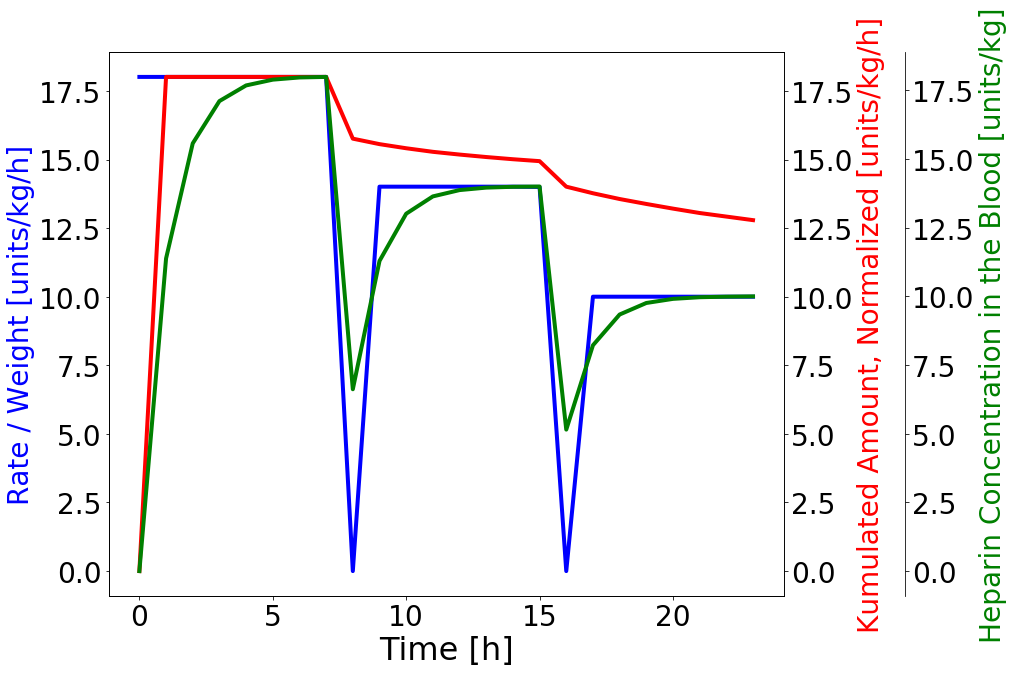

In [12]:
fig, ax = plt.subplots(figsize=(15,10))

axes = [ax, ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.18))

stay_id = 30101153

axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

axes[0].plot(t,case1_hep.loc[stay_id][1], color='b', linewidth=4)
axes[0].set_xlabel('Time [h]', fontsize=32)
axes[0].set_ylabel('Rate / Weight [units/kg/h]', color='b', fontsize=28)
axes[1].plot(t,case2_hep.loc[stay_id][1], color='r', linewidth=4)
axes[1].set_ylabel('Kumulated Amount, Normalized [units/kg/h]', color='r', fontsize=28)
axes[2].plot(t,case3_hep.loc[stay_id][1], color='g', linewidth=4)
axes[2].set_ylabel('Heparin Concentration in the Blood [units/kg]', color='g', fontsize=28)
axes[0].tick_params(axis='x', labelsize=28)
axes[0].tick_params(axis='y', labelsize=28)
axes[1].tick_params(axis='y', labelsize=28)
axes[2].tick_params(axis='y', labelsize=28)